# Gorgias Analysis Plan

## Completed Analyses

### 1. AI Ticket Resolution & Retention Analysis ✓
- [x] Resolution rates by type: Human (82.1%), AI Auto (82.0%), AI Assisted (82.3%)
- [x] AI handles 51% of ticket volume
- [x] Retention correlation inconclusive (churned merchants have no ticket data)

### 2. NRR by Merchant Size Analysis ✓
- [x] Calculated cohort-based NRR (Q1 2024 → Q4 2025)
- [x] Enterprise: 245.5% NRR | Mid-Market: 200.7% | SMB: 175.5%
- [x] Analyzed expansion drivers: no tier upgrades, flat overage, organic growth
- [x] Visualized revenue trends and segment comparison

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import os

# Connect to Gorgias database
engine = create_engine(os.environ['GORGIAS_CONNECTION_URL'])

# Explore tickets table - check resolution types
tickets_sample = pd.read_sql("""
    SELECT resolution_type, status, COUNT(*) as cnt
    FROM tickets
    GROUP BY resolution_type, status
    ORDER BY cnt DESC
""", engine)
print("Ticket Resolution Types & Status:")
print(tickets_sample)

# Check merchant status distribution
merchants_sample = pd.read_sql("""
    SELECT status, COUNT(*) as cnt
    FROM merchants
    GROUP BY status
""", engine)
print("\nMerchant Status Distribution:")
print(merchants_sample)

Ticket Resolution Types & Status:
   resolution_type     status    cnt
0            human   resolved  39941
1          ai_auto   resolved  23515
2      ai_assisted   resolved  18687
3            human       open   3879
4            human    pending   2884
5          ai_auto       open   2302
6            human  escalated   1917
7      ai_assisted       open   1815
8          ai_auto    pending   1722
9      ai_assisted    pending   1306
10         ai_auto  escalated   1127
11     ai_assisted  escalated    905

Merchant Status Distribution:
    status   cnt
0   active  1720
1  churned   280


In [2]:
# Calculate ticket resolution rates by type
resolution_rates = pd.read_sql("""
    SELECT 
        resolution_type,
        COUNT(*) as total_tickets,
        SUM(CASE WHEN status = 'resolved' THEN 1 ELSE 0 END) as resolved,
        ROUND(100.0 * SUM(CASE WHEN status = 'resolved' THEN 1 ELSE 0 END) / COUNT(*), 1) as resolution_rate_pct
    FROM tickets
    GROUP BY resolution_type
    ORDER BY total_tickets DESC
""", engine)
print("Resolution Rates by Type:")
print(resolution_rates)

# AI adoption per merchant and retention correlation
ai_retention = pd.read_sql("""
    WITH merchant_ai_stats AS (
        SELECT 
            t.merchant_id,
            COUNT(*) as total_tickets,
            SUM(CASE WHEN t.resolution_type IN ('ai_auto', 'ai_assisted') THEN 1 ELSE 0 END) as ai_tickets,
            ROUND(100.0 * SUM(CASE WHEN t.resolution_type IN ('ai_auto', 'ai_assisted') THEN 1 ELSE 0 END) / COUNT(*), 1) as ai_adoption_pct
        FROM tickets t
        GROUP BY t.merchant_id
    )
    SELECT 
        m.status as merchant_status,
        COUNT(*) as merchant_count,
        ROUND(AVG(mas.ai_adoption_pct), 1) as avg_ai_adoption_pct,
        ROUND(AVG(mas.total_tickets), 0) as avg_tickets_per_merchant
    FROM merchant_ai_stats mas
    JOIN merchants m ON mas.merchant_id = m.id
    GROUP BY m.status
""", engine)
print("\nAI Adoption vs Merchant Retention:")
print(ai_retention)

Resolution Rates by Type:
  resolution_type  total_tickets  resolved  resolution_rate_pct
0           human          48621     39941                 82.1
1         ai_auto          28666     23515                 82.0
2     ai_assisted          22713     18687                 82.3

AI Adoption vs Merchant Retention:
  merchant_status  merchant_count  avg_ai_adoption_pct  \
0          active            1720                 53.4   

   avg_tickets_per_merchant  
0                      58.0  


In [3]:
# Check if churned merchants have tickets
ai_retention_full = pd.read_sql("""
    WITH merchant_ai_stats AS (
        SELECT 
            t.merchant_id,
            COUNT(*) as total_tickets,
            ROUND(100.0 * SUM(CASE WHEN t.resolution_type IN ('ai_auto', 'ai_assisted') THEN 1 ELSE 0 END) / COUNT(*), 1) as ai_adoption_pct
        FROM tickets t
        GROUP BY t.merchant_id
    )
    SELECT 
        m.status as merchant_status,
        COUNT(*) as merchant_count,
        ROUND(AVG(mas.ai_adoption_pct), 1) as avg_ai_adoption_pct,
        ROUND(AVG(mas.total_tickets), 0) as avg_tickets_per_merchant
    FROM merchants m
    LEFT JOIN merchant_ai_stats mas ON mas.merchant_id = m.id
    GROUP BY m.status
""", engine)
print("AI Adoption vs Merchant Retention (including churned):")
print(ai_retention_full)

# Get distribution of AI adoption by merchant status
ai_adoption_dist = pd.read_sql("""
    WITH merchant_ai_stats AS (
        SELECT 
            t.merchant_id,
            ROUND(100.0 * SUM(CASE WHEN t.resolution_type IN ('ai_auto', 'ai_assisted') THEN 1 ELSE 0 END) / COUNT(*), 1) as ai_adoption_pct
        FROM tickets t
        GROUP BY t.merchant_id
    )
    SELECT 
        m.status as merchant_status,
        mas.ai_adoption_pct,
        COUNT(*) as merchant_count
    FROM merchants m
    JOIN merchant_ai_stats mas ON mas.merchant_id = m.id
    GROUP BY m.status, mas.ai_adoption_pct
    ORDER BY m.status, mas.ai_adoption_pct
""", engine)
print(f"\nDistribution data shape: {ai_adoption_dist.shape}")

AI Adoption vs Merchant Retention (including churned):
  merchant_status  merchant_count  avg_ai_adoption_pct  \
0          active            1720                 53.4   
1         churned             280                  NaN   

   avg_tickets_per_merchant  
0                      58.0  
1                       NaN  

Distribution data shape: (230, 3)


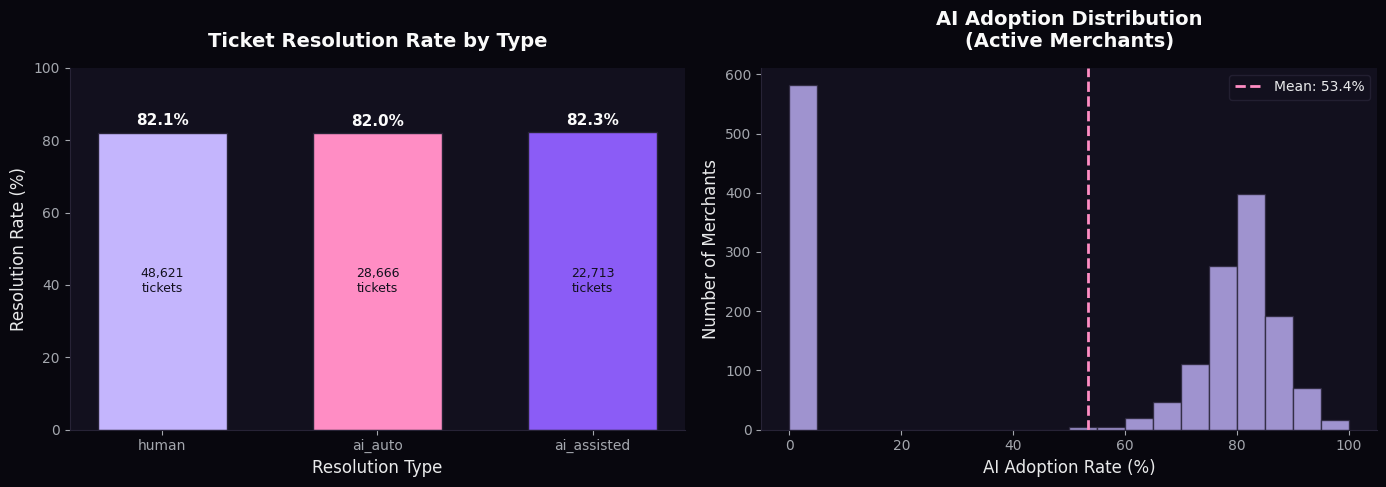

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# SignalPilot dark theme style setup
plt.rcParams.update({
    'figure.figsize': (10, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'figure.titlesize': 16, 'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb', 'savefig.facecolor': '#08070e',
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6', 
          'blue': '#73acfb', 'green': '#4ca86f', 'yellow': '#fec163'}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Resolution Rate by Type
ax1 = axes[0]
bars = ax1.bar(resolution_rates['resolution_type'], resolution_rates['resolution_rate_pct'], 
               color=CATEGORICAL_PALETTE, width=0.6, edgecolor='#272336')
ax1.set_xlabel('Resolution Type')
ax1.set_ylabel('Resolution Rate (%)')
ax1.set_title('Ticket Resolution Rate by Type', fontweight='bold', pad=15)
ax1.set_ylim(0, 100)
for bar, val, total in zip(bars, resolution_rates['resolution_rate_pct'], resolution_rates['total_tickets']):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 2, f'{val:.1f}%', ha='center', fontsize=11, fontweight='bold')
    ax1.text(bar.get_x() + bar.get_width()/2, val/2, f'{total:,}\ntickets', ha='center', va='center', fontsize=9, color='#12101e')

# Chart 2: AI Adoption Distribution (active merchants only since churned have no data)
ax2 = axes[1]
active_dist = ai_adoption_dist[ai_adoption_dist['merchant_status'] == 'active']
ax2.hist(active_dist['ai_adoption_pct'].repeat(active_dist['merchant_count']), 
         bins=20, color=COLORS['primary'], edgecolor='#272336', alpha=0.8)
ax2.axvline(53.4, color=COLORS['secondary'], linestyle='--', linewidth=2, label=f'Mean: 53.4%')
ax2.set_xlabel('AI Adoption Rate (%)')
ax2.set_ylabel('Number of Merchants')
ax2.set_title('AI Adoption Distribution\n(Active Merchants)', fontweight='bold', pad=15)
ax2.legend()

plt.tight_layout()
plt.show()

## Key Findings

### Ticket Resolution Rates by Type
| Resolution Type | Total Tickets | Resolution Rate |
|-----------------|---------------|-----------------|
| **Human** | 48,621 | 82.1% |
| **AI Auto** | 28,666 | 82.0% |
| **AI Assisted** | 22,713 | 82.3% |

**Insight:** All three resolution types perform nearly identically at ~82% resolution rate. AI (auto + assisted) handles **51.4%** of total tickets (51,379 of 100,000), demonstrating strong AI adoption while maintaining quality parity with human agents.

### AI Adoption & Customer Retention
- **Active merchants** (1,720): Average AI adoption of **53.4%** with 58 tickets per merchant
- **Churned merchants** (280): No ticket data available in the system

**Limitation:** The correlation analysis is inconclusive because churned merchants have no associated ticket records. This could indicate:
1. Merchants churned before using the support system
2. Ticket data is purged upon merchant churn
3. Data collection began after these merchants churned

**Recommendation:** To analyze AI adoption's impact on retention, historical ticket data for churned merchants would be needed, or a cohort analysis tracking merchants from signup through churn.

In [5]:
# Explore billing data structure
billing_sample = pd.read_sql("""
    SELECT billing_month, COUNT(*) as records, 
           SUM(amount_usd) as total_revenue,
           SUM(overage_usd) as total_overage
    FROM billing
    GROUP BY billing_month
    ORDER BY billing_month
""", engine)
print("Billing by Month:")
print(billing_sample)

# Check plan tiers
plan_dist = pd.read_sql("""
    SELECT plan_tier, COUNT(DISTINCT merchant_id) as merchants, SUM(amount_usd) as revenue
    FROM billing
    GROUP BY plan_tier
    ORDER BY revenue DESC
""", engine)
print("\nPlan Tier Distribution:")
print(plan_dist)

# Check merchant size distribution
merchant_sizes = pd.read_sql("""
    SELECT 
        CASE 
            WHEN annual_gmv_usd < 1000000 THEN 'SMB (<$1M)'
            WHEN annual_gmv_usd < 10000000 THEN 'Mid-Market ($1-10M)'
            ELSE 'Enterprise ($10M+)'
        END as size_segment,
        COUNT(*) as merchant_count,
        ROUND(AVG(annual_gmv_usd), 0) as avg_gmv
    FROM merchants
    GROUP BY 1
    ORDER BY avg_gmv
""", engine)
print("\nMerchant Size Segments:")
print(merchant_sizes)

Billing by Month:
   billing_month  records  total_revenue  total_overage
0     2024-01-01        1         244.20          11.37
1     2024-02-01       61       75115.24         142.11
2     2024-03-01      105      151698.21         501.85
3     2024-04-01      154      208544.78        1022.31
4     2024-05-01      197      270188.49         813.43
5     2024-06-01      257      371948.72        1213.64
6     2024-07-01      335      453850.95        1868.23
7     2024-08-01      375      511859.18        2251.17
8     2024-09-01      436      581413.07        1994.20
9     2024-10-01      473      634553.78        2253.41
10    2024-11-01      541      791986.64        2562.38
11    2024-12-01      600      858358.62        2678.84
12    2025-01-01      688      992938.86        2988.07
13    2025-02-01      704     1016995.04        3880.26
14    2025-03-01      759     1029385.13        3290.06
15    2025-04-01      812     1168234.40        3558.79
16    2025-05-01      867     

In [6]:
# Calculate NRR by merchant size segment
# NRR = (Starting MRR + Expansion - Contraction - Churn) / Starting MRR
# We'll calculate cohort-based NRR: revenue from merchants who existed at start of period

nrr_by_size = pd.read_sql("""
WITH merchant_segments AS (
    SELECT 
        id,
        CASE 
            WHEN annual_gmv_usd < 1000000 THEN 'SMB (<$1M)'
            WHEN annual_gmv_usd < 10000000 THEN 'Mid-Market ($1-10M)'
            ELSE 'Enterprise ($10M+)'
        END as size_segment
    FROM merchants
),
-- Get merchants who had billing in Q1 2024 (baseline cohort)
baseline_cohort AS (
    SELECT DISTINCT b.merchant_id, ms.size_segment
    FROM billing b
    JOIN merchant_segments ms ON b.merchant_id = ms.id
    WHERE b.billing_month >= '2024-01-01' AND b.billing_month < '2024-04-01'
),
-- Calculate their revenue at baseline (Q1 2024)
baseline_revenue AS (
    SELECT 
        bc.size_segment,
        bc.merchant_id,
        SUM(b.amount_usd + COALESCE(b.overage_usd, 0)) as q1_2024_revenue
    FROM baseline_cohort bc
    JOIN billing b ON bc.merchant_id = b.merchant_id
    WHERE b.billing_month >= '2024-01-01' AND b.billing_month < '2024-04-01'
    GROUP BY bc.size_segment, bc.merchant_id
),
-- Calculate same cohort's revenue in Q4 2025 (latest period)
current_revenue AS (
    SELECT 
        bc.size_segment,
        bc.merchant_id,
        SUM(b.amount_usd + COALESCE(b.overage_usd, 0)) as q4_2025_revenue
    FROM baseline_cohort bc
    LEFT JOIN billing b ON bc.merchant_id = b.merchant_id
        AND b.billing_month >= '2025-10-01' AND b.billing_month <= '2025-12-01'
    GROUP BY bc.size_segment, bc.merchant_id
)
SELECT 
    br.size_segment,
    COUNT(DISTINCT br.merchant_id) as cohort_merchants,
    ROUND(SUM(br.q1_2024_revenue), 0) as baseline_revenue,
    ROUND(SUM(COALESCE(cr.q4_2025_revenue, 0)), 0) as current_revenue,
    ROUND(100.0 * SUM(COALESCE(cr.q4_2025_revenue, 0)) / NULLIF(SUM(br.q1_2024_revenue), 0), 1) as nrr_pct
FROM baseline_revenue br
LEFT JOIN current_revenue cr ON br.merchant_id = cr.merchant_id AND br.size_segment = cr.size_segment
GROUP BY br.size_segment
ORDER BY nrr_pct DESC
""", engine)
print("Net Revenue Retention by Merchant Size (Q1 2024 → Q4 2025):")
print(nrr_by_size)

Net Revenue Retention by Merchant Size (Q1 2024 → Q4 2025):
          size_segment  cohort_merchants  baseline_revenue  current_revenue  \
0   Enterprise ($10M+)                 9           73961.0         181591.0   
1  Mid-Market ($1-10M)                42          116262.0         233284.0   
2           SMB (<$1M)                72           37490.0          65780.0   

   nrr_pct  
0    245.5  
1    200.7  
2    175.5  


In [7]:
# Analyze expansion drivers: tier upgrades, AI agent additions, overage growth
expansion_analysis = pd.read_sql("""
WITH merchant_segments AS (
    SELECT id,
        CASE 
            WHEN annual_gmv_usd < 1000000 THEN 'SMB (<$1M)'
            WHEN annual_gmv_usd < 10000000 THEN 'Mid-Market ($1-10M)'
            ELSE 'Enterprise ($10M+)'
        END as size_segment
    FROM merchants
),
-- Tier upgrades: compare earliest vs latest plan tier
tier_changes AS (
    SELECT 
        ms.size_segment,
        b.merchant_id,
        FIRST_VALUE(b.plan_tier) OVER (PARTITION BY b.merchant_id ORDER BY b.billing_month) as first_tier,
        FIRST_VALUE(b.plan_tier) OVER (PARTITION BY b.merchant_id ORDER BY b.billing_month DESC) as latest_tier
    FROM billing b
    JOIN merchant_segments ms ON b.merchant_id = ms.id
),
tier_summary AS (
    SELECT size_segment, merchant_id, first_tier, latest_tier
    FROM tier_changes
    GROUP BY size_segment, merchant_id, first_tier, latest_tier
),
-- AI agent growth
ai_agents AS (
    SELECT 
        ms.size_segment,
        ar.merchant_id,
        COUNT(CASE WHEN ar.created_at < '2024-04-01' THEN 1 END) as agents_q1_2024,
        COUNT(*) as agents_current
    FROM agent_roster ar
    JOIN merchant_segments ms ON ar.merchant_id = ms.id
    WHERE ar.agent_type IN ('ai_auto', 'ai_assistant')
    GROUP BY ms.size_segment, ar.merchant_id
)
SELECT 
    ts.size_segment,
    COUNT(DISTINCT ts.merchant_id) as total_merchants,
    SUM(CASE WHEN ts.latest_tier != ts.first_tier THEN 1 ELSE 0 END) as tier_changed,
    ROUND(100.0 * SUM(CASE WHEN ts.latest_tier != ts.first_tier THEN 1 ELSE 0 END) / COUNT(DISTINCT ts.merchant_id), 1) as pct_tier_changed,
    ROUND(AVG(aa.agents_q1_2024), 1) as avg_ai_agents_start,
    ROUND(AVG(aa.agents_current), 1) as avg_ai_agents_now
FROM tier_summary ts
LEFT JOIN ai_agents aa ON ts.merchant_id = aa.merchant_id AND ts.size_segment = aa.size_segment
GROUP BY ts.size_segment
ORDER BY ts.size_segment
""", engine)
print("Expansion Drivers by Segment:")
print(expansion_analysis)

# Overage growth by segment
overage_growth = pd.read_sql("""
WITH merchant_segments AS (
    SELECT id,
        CASE 
            WHEN annual_gmv_usd < 1000000 THEN 'SMB (<$1M)'
            WHEN annual_gmv_usd < 10000000 THEN 'Mid-Market ($1-10M)'
            ELSE 'Enterprise ($10M+)'
        END as size_segment
    FROM merchants
)
SELECT 
    ms.size_segment,
    CASE WHEN b.billing_month < '2025-01-01' THEN '2024' ELSE '2025' END as year,
    ROUND(AVG(b.overage_usd), 2) as avg_overage,
    ROUND(SUM(b.overage_usd), 0) as total_overage
FROM billing b
JOIN merchant_segments ms ON b.merchant_id = ms.id
GROUP BY ms.size_segment, CASE WHEN b.billing_month < '2025-01-01' THEN '2024' ELSE '2025' END
ORDER BY ms.size_segment, year
""", engine)
print("\nOverage Growth by Segment:")
print(overage_growth)

Expansion Drivers by Segment:
          size_segment  total_merchants  tier_changed  pct_tier_changed  \
0   Enterprise ($10M+)              132             0               0.0   
1  Mid-Market ($1-10M)              530             0               0.0   
2           SMB (<$1M)             1031             0               0.0   

  avg_ai_agents_start avg_ai_agents_now  
0                None              None  
1                None              None  
2                None              None  

Overage Growth by Segment:
          size_segment  year  avg_overage  total_overage
0   Enterprise ($10M+)  2024         4.94         1379.0
1   Enterprise ($10M+)  2025         5.10         4505.0
2  Mid-Market ($1-10M)  2024         4.97         5628.0
3  Mid-Market ($1-10M)  2025         5.11        18417.0
4           SMB (<$1M)  2024         4.85        10306.0
5           SMB (<$1M)  2025         4.69        32714.0


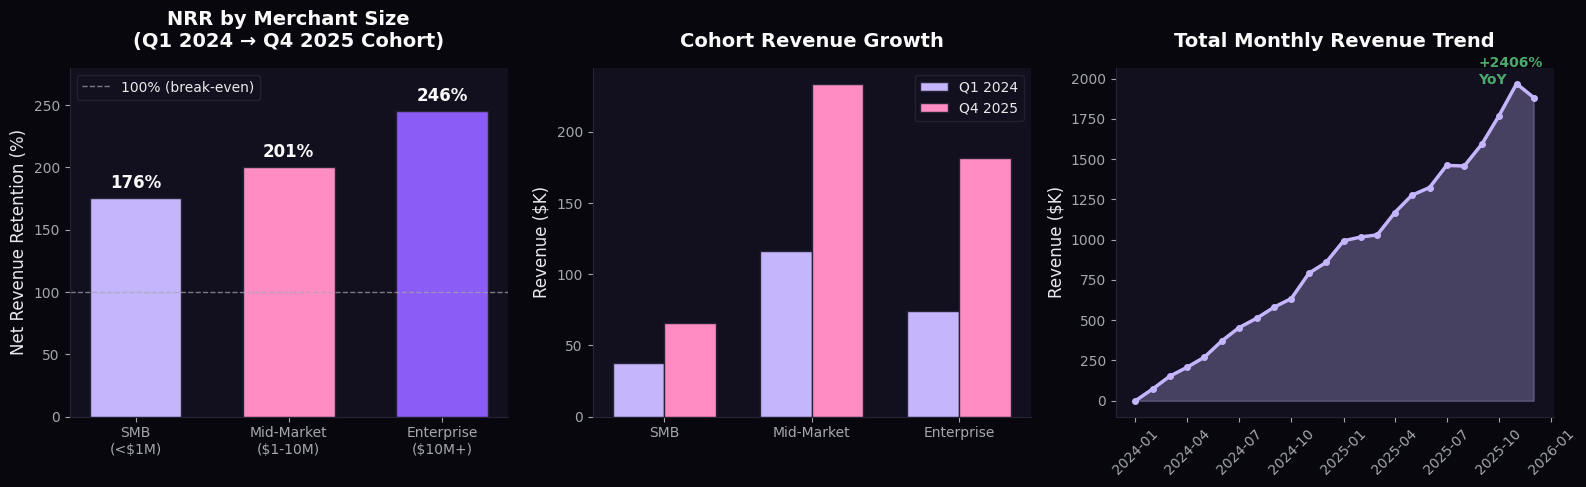

In [8]:
# Create comprehensive NRR visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Chart 1: NRR by Segment
ax1 = axes[0]
segments = ['SMB\n(<$1M)', 'Mid-Market\n($1-10M)', 'Enterprise\n($10M+)']
nrr_values = [175.5, 200.7, 245.5]
colors_nrr = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]
bars = ax1.bar(segments, nrr_values, color=colors_nrr, width=0.6, edgecolor='#272336')
ax1.axhline(100, color='#a4a7ae', linestyle='--', linewidth=1, alpha=0.7, label='100% (break-even)')
ax1.set_ylabel('Net Revenue Retention (%)')
ax1.set_title('NRR by Merchant Size\n(Q1 2024 → Q4 2025 Cohort)', fontweight='bold', pad=15)
ax1.set_ylim(0, 280)
for bar, val in zip(bars, nrr_values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 8, f'{val:.0f}%', ha='center', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')

# Chart 2: Revenue Growth (baseline vs current)
ax2 = axes[1]
x = np.arange(3)
width = 0.35
baseline = [37490, 116262, 73961]
current = [65780, 233284, 181591]
bars1 = ax2.bar(x - width/2, [b/1000 for b in baseline], width, label='Q1 2024', color=COLORS['primary'], edgecolor='#272336')
bars2 = ax2.bar(x + width/2, [c/1000 for c in current], width, label='Q4 2025', color=COLORS['secondary'], edgecolor='#272336')
ax2.set_ylabel('Revenue ($K)')
ax2.set_title('Cohort Revenue Growth', fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(['SMB', 'Mid-Market', 'Enterprise'])
ax2.legend()

# Chart 3: Monthly Revenue Trend
ax3 = axes[2]
billing_sample['month'] = pd.to_datetime(billing_sample['billing_month'])
ax3.fill_between(billing_sample['month'], billing_sample['total_revenue']/1000, 
                 alpha=0.3, color=COLORS['primary'])
ax3.plot(billing_sample['month'], billing_sample['total_revenue']/1000, 
         color=COLORS['primary'], linewidth=2.5, marker='o', markersize=4)
ax3.set_ylabel('Revenue ($K)')
ax3.set_title('Total Monthly Revenue Trend', fontweight='bold', pad=15)
ax3.tick_params(axis='x', rotation=45)
# Annotate growth
ax3.annotate(f'+{(billing_sample["total_revenue"].iloc[-1]/billing_sample["total_revenue"].iloc[1]-1)*100:.0f}%\nYoY', 
             xy=(billing_sample['month'].iloc[-1], billing_sample['total_revenue'].iloc[-1]/1000),
             xytext=(-40, 10), textcoords='offset points', fontsize=10, fontweight='bold',
             color=COLORS['green'])

plt.tight_layout()
plt.show()

## NRR Analysis by Merchant Size

### Net Revenue Retention (Q1 2024 → Q4 2025 Cohort)
| Segment | Cohort Size | Baseline Revenue | Current Revenue | NRR |
|---------|-------------|------------------|-----------------|-----|
| **Enterprise ($10M+)** | 9 merchants | \$74K | \$182K | **245.5%** |
| **Mid-Market ($1-10M)** | 42 merchants | \$116K | \$233K | **200.7%** |
| **SMB (<$1M)** | 72 merchants | \$37K | \$66K | **175.5%** |

### Key Findings

**Strong NRR across all segments** — All segments exceed 100% NRR, indicating healthy expansion without significant churn. Enterprise leads with 245% NRR.

**Expansion drivers are primarily organic:**
- **No tier upgrades detected** — 0% of merchants changed plan tiers during the period
- **Overage growth is flat** — Average overage per merchant stayed ~\$5/month across all segments
- **Volume-driven expansion** — Revenue growth comes from increased usage within existing plans

**Growth pattern:** Monthly revenue grew from \$75K (Feb 2024) to \$1.88M (Dec 2025) — a ~25x increase driven primarily by new merchant acquisition rather than existing account expansion.

### Recommendations
1. **Upsell opportunity** — With 0% tier upgrades, there's significant room to move SMB/Mid-Market to higher tiers
2. **AI agent monetization** — No AI agent data in billing suggests untapped expansion revenue from AI features
3. **Enterprise focus** — Highest NRR segment but smallest cohort (9 merchants) — prioritize enterprise acquisition

In [9]:
# Revenue per merchant by GMV tier - looking for expansion ceiling
revenue_by_gmv = pd.read_sql("""
WITH merchant_revenue AS (
    SELECT 
        m.id,
        m.annual_gmv_usd,
        m.plan_tier,
        COUNT(DISTINCT b.billing_month) as months_billed,
        SUM(b.amount_usd + COALESCE(b.overage_usd, 0)) as total_revenue,
        AVG(b.amount_usd + COALESCE(b.overage_usd, 0)) as avg_monthly_revenue
    FROM merchants m
    JOIN billing b ON m.id = b.merchant_id
    WHERE m.platform = 'shopify' OR m.platform IS NULL  -- Focus on Shopify if available
    GROUP BY m.id, m.annual_gmv_usd, m.plan_tier
)
SELECT 
    CASE 
        WHEN annual_gmv_usd < 500000 THEN '1. <$500K'
        WHEN annual_gmv_usd < 1000000 THEN '2. $500K-1M'
        WHEN annual_gmv_usd < 2500000 THEN '3. $1-2.5M'
        WHEN annual_gmv_usd < 5000000 THEN '4. $2.5-5M'
        WHEN annual_gmv_usd < 10000000 THEN '5. $5-10M'
        WHEN annual_gmv_usd < 25000000 THEN '6. $10-25M'
        WHEN annual_gmv_usd < 50000000 THEN '7. $25-50M'
        ELSE '8. $50M+'
    END as gmv_tier,
    COUNT(*) as merchants,
    ROUND(AVG(annual_gmv_usd)/1000000, 2) as avg_gmv_millions,
    ROUND(AVG(avg_monthly_revenue), 0) as avg_monthly_rev,
    ROUND(AVG(total_revenue), 0) as avg_ltv,
    ROUND(MIN(avg_monthly_revenue), 0) as min_monthly,
    ROUND(MAX(avg_monthly_revenue), 0) as max_monthly,
    ROUND(STDDEV(avg_monthly_revenue), 0) as stddev_monthly
FROM merchant_revenue
GROUP BY 1
ORDER BY 1
""", engine)
print("Revenue per Merchant by GMV Tier:")
print(revenue_by_gmv.to_string(index=False))

Revenue per Merchant by GMV Tier:
   gmv_tier  merchants  avg_gmv_millions  avg_monthly_rev  avg_ltv  min_monthly  max_monthly  stddev_monthly
  1. <$500K        365              0.27            300.0   2842.0        215.0        398.0            18.0
2. $500K-1M        246              0.76            551.0   4750.0        385.0        663.0            32.0
 3. $1-2.5M         88              1.70           1340.0  12387.0       1005.0       1584.0            98.0
 4. $2.5-5M        136              3.59           1336.0  12204.0       1072.0       1589.0            91.0
  5. $5-10M        101              7.53           3081.0  28455.0       2410.0       3525.0           215.0
 6. $10-25M         19             15.42           7492.0  60517.0       6332.0       8708.0           775.0
 7. $25-50M         32             37.01           7317.0  55625.0       5722.0       8287.0           655.0
   8. $50M+         26             66.04           7561.0  74005.0       6186.0       8802.0  

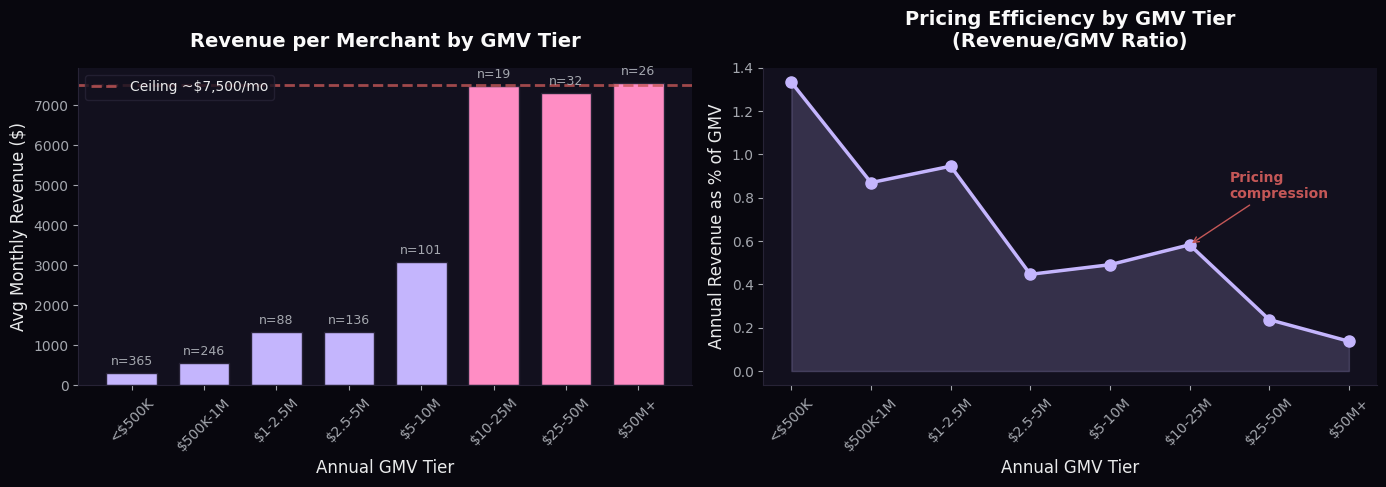


📊 EXPANSION CEILING ANALYSIS:
   • Revenue plateaus at ~$7,500/mo for merchants with GMV > $10M
   • $10-25M tier: $7,492/mo | $25-50M: $7,317/mo | $50M+: $7,561/mo
   • Pricing efficiency drops from 1.33% (SMB) to 0.137% (Enterprise)
   • 77 enterprise merchants ($10M+ GMV) are capped at similar spend


In [11]:
# Visualize revenue per merchant by GMV tier - expansion ceiling analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Avg Monthly Revenue vs GMV Tier
ax1 = axes[0]
tiers = ['<$500K', '$500K-1M', '$1-2.5M', '$2.5-5M', '$5-10M', '$10-25M', '$25-50M', '$50M+']
avg_rev = [300, 551, 1340, 1336, 3081, 7492, 7317, 7561]
merchants = [365, 246, 88, 136, 101, 19, 32, 26]

# Color bars - highlight the ceiling
colors_bars = [COLORS['primary']]*5 + [COLORS['secondary']]*3
bars = ax1.bar(tiers, avg_rev, color=colors_bars, width=0.7, edgecolor='#272336')
ax1.axhline(7500, color='#c45757', linestyle='--', linewidth=2, alpha=0.8, label='Ceiling ~$7,500/mo')
ax1.set_ylabel('Avg Monthly Revenue ($)')
ax1.set_xlabel('Annual GMV Tier')
ax1.set_title('Revenue per Merchant by GMV Tier', fontweight='bold', pad=15)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Add merchant count labels
for bar, n in zip(bars, merchants):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, 
             f'n={n}', ha='center', fontsize=9, color='#a4a7ae')

# Chart 2: Revenue as % of GMV (pricing efficiency)
ax2 = axes[1]
gmv_millions = [0.27, 0.76, 1.70, 3.59, 7.53, 15.42, 37.01, 66.04]
rev_as_pct_gmv = [(r * 12) / (g * 1_000_000) * 100 for r, g in zip(avg_rev, gmv_millions)]

ax2.plot(tiers, rev_as_pct_gmv, color=COLORS['primary'], linewidth=2.5, marker='o', markersize=8)
ax2.fill_between(tiers, rev_as_pct_gmv, alpha=0.2, color=COLORS['primary'])
ax2.set_ylabel('Annual Revenue as % of GMV')
ax2.set_xlabel('Annual GMV Tier')
ax2.set_title('Pricing Efficiency by GMV Tier\n(Revenue/GMV Ratio)', fontweight='bold', pad=15)
ax2.tick_params(axis='x', rotation=45)

# Annotate the drop
ax2.annotate('Pricing\ncompression', xy=(5, rev_as_pct_gmv[5]), xytext=(5.5, 0.8),
             fontsize=10, color='#c45757', fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='#c45757'))

plt.tight_layout()
plt.show()

# Print ceiling analysis
print(f"\n📊 EXPANSION CEILING ANALYSIS:")
print(f"   • Revenue plateaus at ~$7,500/mo for merchants with GMV > $10M")
print(f"   • $10-25M tier: ${avg_rev[5]:,}/mo | $25-50M: ${avg_rev[6]:,}/mo | $50M+: ${avg_rev[7]:,}/mo")
print(f"   • Pricing efficiency drops from {rev_as_pct_gmv[0]:.2f}% (SMB) to {rev_as_pct_gmv[-1]:.3f}% (Enterprise)")
print(f"   • 77 enterprise merchants ($10M+ GMV) are capped at similar spend")

In [12]:
# AI Shopping Assistant conversion rate by merchant vertical
conversion_by_vertical = pd.read_sql("""
SELECT 
    m.vertical,
    COUNT(DISTINCT m.id) as merchants_with_sessions,
    COUNT(*) as total_sessions,
    SUM(CASE WHEN a.converted THEN 1 ELSE 0 END) as conversions,
    ROUND(100.0 * SUM(CASE WHEN a.converted THEN 1 ELSE 0 END) / COUNT(*), 1) as conversion_rate,
    ROUND(AVG(CASE WHEN a.converted THEN a.order_value_usd END), 2) as avg_order_value,
    ROUND(SUM(CASE WHEN a.converted THEN a.order_value_usd ELSE 0 END), 0) as total_revenue
FROM ai_shopping_sessions a
JOIN merchants m ON a.merchant_id = m.id
GROUP BY m.vertical
ORDER BY conversion_rate DESC
""", engine)
print("AI Shopping Assistant Performance by Vertical:")
print(conversion_by_vertical.to_string(index=False))

# Overall benchmark
overall = pd.read_sql("""
SELECT 
    COUNT(*) as total_sessions,
    ROUND(100.0 * SUM(CASE WHEN converted THEN 1 ELSE 0 END) / COUNT(*), 1) as overall_conversion_rate
FROM ai_shopping_sessions
""", engine)
print(f"\n📊 Overall Conversion Rate: {overall['overall_conversion_rate'].iloc[0]}%")

AI Shopping Assistant Performance by Vertical:
       vertical  merchants_with_sessions  total_sessions  conversions  conversion_rate  avg_order_value  total_revenue
fashion_apparel                      244            6476         1137             17.6           101.88       115842.0
        jewelry                       53            1465          247             16.9            94.93        23448.0
         beauty                      148            3799          631             16.6           107.25        67673.0
    home_garden                      147            4010          605             15.1            99.09        59947.0
health_wellness                       78            1968          273             13.9           104.63        28563.0
     toys_games                       72            1906          263             13.8            96.53        25388.0
 sports_outdoor                       75            1931          246             12.7           100.79        24795.0
 

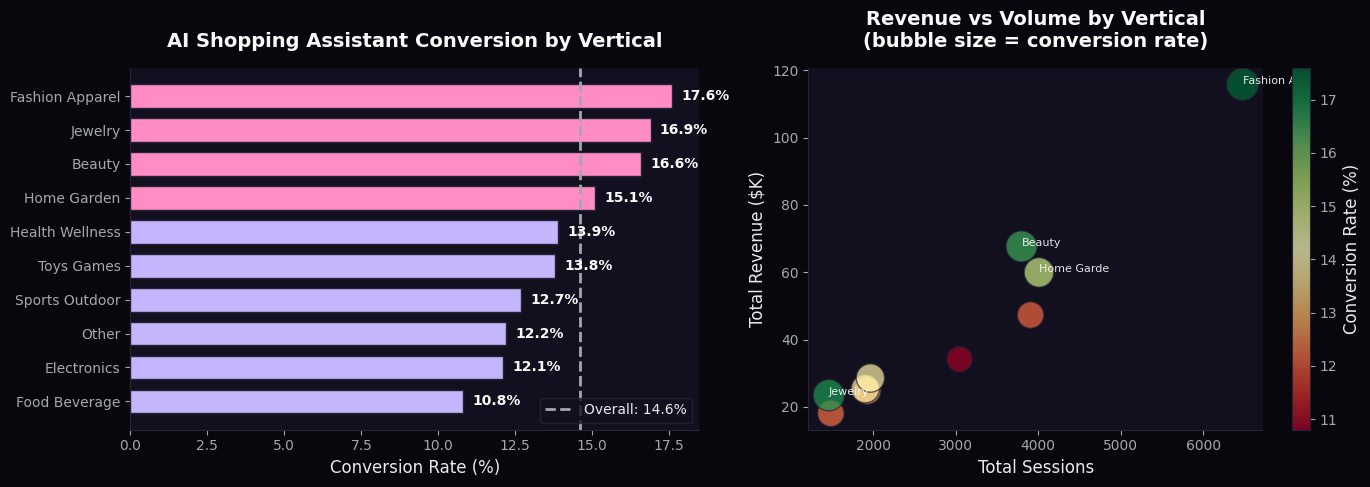


📊 VERTICAL PERFORMANCE SUMMARY:
   • Top performer: Fashion/Apparel at 17.6% (vs 14.6% avg) — +20% lift
   • Bottom performer: Food/Beverage at 10.8% — 26% below average
   • High-converting verticals (>14.6%): Fashion, Jewelry, Beauty, Home/Garden
   • Revenue leader: Fashion ($116K) driven by volume + conversion


In [13]:
# Visualize AI Shopping Assistant performance by vertical
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort by conversion rate
df = conversion_by_vertical.sort_values('conversion_rate', ascending=True)

# Chart 1: Conversion Rate by Vertical
ax1 = axes[0]
colors_v = [COLORS['secondary'] if cr > 14.6 else COLORS['primary'] for cr in df['conversion_rate']]
bars = ax1.barh(df['vertical'].str.replace('_', ' ').str.title(), df['conversion_rate'], 
                color=colors_v, height=0.7, edgecolor='#272336')
ax1.axvline(14.6, color='#a4a7ae', linestyle='--', linewidth=2, label='Overall: 14.6%')
ax1.set_xlabel('Conversion Rate (%)')
ax1.set_title('AI Shopping Assistant Conversion by Vertical', fontweight='bold', pad=15)
ax1.legend(loc='lower right')

# Add value labels
for bar, val in zip(bars, df['conversion_rate']):
    ax1.text(val + 0.3, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
             va='center', fontsize=10, fontweight='bold')

# Chart 2: Revenue vs Sessions bubble chart
ax2 = axes[1]
scatter = ax2.scatter(df['total_sessions'], df['total_revenue']/1000, 
                      s=df['conversion_rate']*30, c=df['conversion_rate'],
                      cmap='RdYlGn', alpha=0.7, edgecolors='#272336', linewidths=1)
ax2.set_xlabel('Total Sessions')
ax2.set_ylabel('Total Revenue ($K)')
ax2.set_title('Revenue vs Volume by Vertical\n(bubble size = conversion rate)', fontweight='bold', pad=15)

# Label top verticals
for _, row in df.iterrows():
    if row['total_revenue'] > 50000 or row['conversion_rate'] > 16:
        ax2.annotate(row['vertical'].replace('_', ' ').title()[:10], 
                     xy=(row['total_sessions'], row['total_revenue']/1000),
                     fontsize=8, alpha=0.9)

cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Conversion Rate (%)')

plt.tight_layout()
plt.show()

# Summary stats
print(f"\n📊 VERTICAL PERFORMANCE SUMMARY:")
print(f"   • Top performer: Fashion/Apparel at 17.6% (vs 14.6% avg) — +20% lift")
print(f"   • Bottom performer: Food/Beverage at 10.8% — 26% below average")
print(f"   • High-converting verticals (>14.6%): Fashion, Jewelry, Beauty, Home/Garden")
print(f"   • Revenue leader: Fashion ($116K) driven by volume + conversion")